# Fonctions d'ordonnancement

In [3]:
import matplotlib.pyplot as plt
import random 
import numpy as np
import copy 

## Fonction de calcul de coût d'un ordonnancement 

In [4]:
def genOrdo(n_patient):
    #Génère un ordonnancement au hasard -> Sert uniquement en test
    
    return [[random.randint(5,10),random.randint(10,30),random.randint(40,120),random.randint(10,30)] for _ in range(n_patient)]

def choixRessource(phase):
    #Soit phase une liste de ressources, cette fonction détermine quelle ressource prend la tâche
    
    mini = phase[0][-1][1]+phase[0][-1][2]
    index = 0
    
    found = False
    iRessource = 0
    
    while (not found) and iRessource < len(phase):
        ressource = phase[iRessource]
        if ressource == [(0,0,0)]:
            found = True
            index = iRessource
        elif ressource[-1][1]+ressource[-1][2] < mini:
            mini = ressource[-1][1]+ressource[-1][2]
            index = iRessource
        iRessource+=1
            
    return index

def searchPatient(ind, phase):
    #Trouve le patient n°ind dans la phase *phase*
    
    found = False
    iPhase = 0
    
    while (not found) and iPhase < len(phase):
        ressource = phase[iPhase]
        iRessource = 0
        while iRessource < len(ressource):
            patient = ressource[iRessource]
            if patient[0] == ind:
                found = True
                reponse = patient
            iRessource += 1
        iPhase+=1
    
    if found:
        return reponse
    else: 
        return None
    
def decalPhase(ind, phase, delai):
    #Cette fonction décale d'un temps delai le patient ind dans la phase *phase*
    
    found = False
    iPhase = 0
    
    while (not found) and iPhase < len(phase):
        ressource = phase[iPhase]
        iRessource = 0
        while iRessource < len(ressource):
            patient = ressource[iRessource]
            if patient[0] == ind:
                found = True
                phase[iPhase][iRessource] = (phase[iPhase][iRessource][0], phase[iPhase][iRessource][1] + delai, phase[iPhase][iRessource][2]) # Un tuple n'est pas modifiable donc je dois le remplacer avec la nouvelle valeur
            iRessource += 1
        iPhase+=1
        

def arrangementFinal(ordo, nSSPIEntree = 3, nSSPIReveil = 3, nBloc = 4, nChir = 5, nAnesthesiste = 8, nBrancardier = 2):
    #Construit l'arrangement final en prenant en compte toutes les contraintes de ressources et de capacité
    
    # Initialisation des listes de phases qui représentent le passage 
    # des patients dans chaque 'phase' : dans chaque phase il y a nPhase ressources
    # et dans chaque ressource il y aura des patients au format (id du patient, instant de début de la tâche, duree de la tâche)
    
    ordresBrancardiers = [[(0, 0, 0)] for _ in range(nBrancardier)]
    ordresSSPIEntrees = [[(0, 0, 0)] for _ in range(nSSPIEntree)]
    ordresBlocs = [[(0, 0, 0)] for _ in range(nBloc)]
    ordresSSPIReveils = [[(0, 0, 0)] for _ in range(nSSPIReveil)]
    
    for ind, patient in enumerate(ordo):
        
        # Choix du bloc : attribution prioritaire car c'est ce qu'on optimise, et les autres taches en dépendent
        bloc = choixRessource(ordresBlocs)
        if ordresBlocs[bloc] == [(0, 0, 0)] :     # Pour traiter les premiers cas, dû à l'initialisation, on remplace au lieu d'ajouter
            ordresBlocs[bloc] = [(ind, 0, patient[2])]
        else :
            readyTime = ordresBlocs[bloc][-1][1] + ordresBlocs[bloc][-1][2] + 10
            ordresBlocs[bloc].append((ind, readyTime, patient[2]))
        
        # Choix du lit SSPI + attribution du patient:
        litSSPIEntree = choixRessource(ordresSSPIEntrees)
        blocPhase = searchPatient(ind, ordresBlocs) # On retrouve les données de ce patient au bloc
        if ordresSSPIEntrees[litSSPIEntree] == [(0,0,0)] :   # Pour traiter les premiers cas, dû à l'initialisation, on remplace au lieu d'ajouter
            ordresSSPIEntrees[litSSPIEntree] = [(ind, blocPhase[1]-patient[1], patient[1])]
        else : 
            readyTime = ordresSSPIEntrees[litSSPIEntree][-1][1] + ordresSSPIEntrees[litSSPIEntree][-1][2] # fin de la tâche précédente
            if readyTime + patient[1] < blocPhase[1] : # Si la tache a le temps d'être faite entre la fin de la précédente et le début du bloc
                ordresSSPIEntrees[litSSPIEntree].append((ind, blocPhase[1]-patient[1], patient[1]))
            else :     # Si on n'a pas le temps, il faut décaler le bloc
                decalPhase(ind, ordresBlocs, readyTime + patient[1] - blocPhase[1])
                ordresSSPIEntrees[litSSPIEntree].append((ind, readyTime, patient[1]))
        
        # Choix du brancardier + attribution du patient:
        brancardier = choixRessource(ordresBrancardiers)
        SSPIEntreePhase = searchPatient(ind, ordresSSPIEntrees) # On retrouve les données de ce patient au SSPI d'entree
        if ordresBrancardiers[brancardier] == [(0,0,0)] : # Pour traiter les premiers cas, dû à l'initialisation, on remplace au lieu d'ajouter
            ordresBrancardiers[brancardier] =  [(ind, SSPIEntreePhase[1] - patient[0], patient[0])]
        else : 
            readyTime = ordresBrancardiers[brancardier][-1][1] + ordresBrancardiers[brancardier][-1][2] # fin de la tâche précédente
            if readyTime + patient[0] < SSPIEntreePhase[1] : # Si la tache a le temps d'être faite entre la fin de la précédente et le début du SSPI d'entrée
                ordresBrancardiers[brancardier].append((ind, SSPIEntreePhase[1] - patient[0], patient[0]))
            else :     # Si on n'a pas le temps, il faut décaler le SSPI d'entrée et le bloc
                decalPhase(ind, ordresBlocs, readyTime + patient[0] - SSPIEntreePhase[1])
                decalPhase(ind, ordresSSPIEntrees, readyTime + patient[0] - SSPIEntreePhase[1])
                ordresBrancardiers[brancardier].append((ind, readyTime, patient[0]))
            
        # Choix du lit SSPIReveil
        litSSPIReveil = choixRessource(ordresSSPIReveils)
        previousPhase = searchPatient(ind, ordresBlocs) # On retrouve ses données à la phase précédente
        if ordresSSPIReveils[litSSPIReveil] == [(0,0,0)] :   # Pour traiter les premiers cas, dû à l'initialisation, on remplace au lieu d'ajouter
            ordresSSPIReveils[litSSPIReveil] = [(ind, previousPhase[1] + previousPhase[2], patient[3])]
        else : 
            readyTime = max(ordresSSPIReveils[litSSPIReveil][-1][1] + ordresSSPIReveils[litSSPIReveil][-1][2], previousPhase[1] + previousPhase[2])
            ordresSSPIReveils[litSSPIReveil].append((ind, readyTime, patient[3]))
    
    return [ordresBrancardiers, ordresSSPIEntrees, ordresBlocs, ordresSSPIReveils]

def coutOrdo(arrangement):
    #Prend en entree un arrangement et donne son coût temporel total
    
    brancardiers = arrangement[0]
    debut = min([brancardier[0][1] for brancardier in brancardiers])  # date de debut minimale de tous les brancardiers (forcément parmi les premières prises en charge de chacun)
    
    litsReveil = arrangement[-1]
    fin = max(lit[-1][1]+lit[-1][2] for lit in litsReveil) # date de fin maximale de tous les lits de réveil (parmi leur dernière prise en charge)
    
    return fin - debut

def cout(ordo): 
    #Prend en entree un ordo et donne son cout temporel total
    return coutOrdo(arrangementFinal(ordo))

## Algorithme Génétique 

In [103]:
#Ensemble de fonctions intermédiaires 
#Création d'une population Initiale (par permutation des patients)
def PopulationInitiale(ordo, N): 
    n = len(ordo)
    listeNpermutations = []
    for _ in range (N): 
        ordoPermut = copy.deepcopy(ordo)
        random.shuffle(ordoPermut)
        listeNpermutations.append(ordoPermut)
        
    return listeNpermutations
 

#Selection pondérée
def SelectionPondere(population, N):  
    population.sort(key=lambda x : cout(x))
    selection = []
    CoutMin = cout(population[0])
    i = 0 
    Ninit = len(population)
    while i < Ninit and len(selection)<N: 
        Cout = cout(population[i])
        prob = CoutMin/Cout
        if random.random() < prob : 
            selection.append(population[i])
        i+=1 
    
    while len(selection) < N : 
        NewPers = list.copy(population[0])
        random.shuffle(NewPers)
        selection.append(NewPers)
    
    return selection


def Croisement(P1, P2): 
    k = len(P1)
    if k <=3 : 
        if random.random()>=0.5 : return P1 
        else : return P2
        
    else : 
        E1 = list.copy(P1)
        E2 = list.copy(P2)
        J = random.randint(0, k-3)
        #récuperation des indices dans E2 correspondants aux gènes échangés avec E1
        ListeIndiceGene = []
        geneManquantE2 = E2[J:J+2]
        geneManquantE2prime = E2[J:J+2]
        
        for j in range (J,J+2):
            gene = E1[j]
            i = 0 
            bool = True
            while i<k and bool : 
                if E2[i] == gene :
                    if J <= i and i <=J+1 :
                        if len(geneManquantE2) > 1 :geneManquantE2.pop(i-J)
                        else : geneManquantE2 = []
                            
                    else : 
                        ListeIndiceGene.append(i)
                    bool = False 
                i+=1
        
        #échange des gènes pour E2 
        E2[J:J+2] = E1[J:J+2]
        for gene in geneManquantE2 : 
            E2[ListeIndiceGene.pop(random.randint(0,len(ListeIndiceGene)-1))] = gene 
            
        #récupération des indices dans E1 correspondants aux gènes échangés avec E2 
        ListeIndiceGene = []
        geneManquantE1 = E1[J:J+2]
        
        for gene in geneManquantE2prime :
            i = 0 
            bool = True
            while i<k and bool : 
                if E1[i] == gene :
                    if J <= i and i <=J+1 :
                        if len(geneManquantE1) > 1 :geneManquantE1.pop(i-J)
                        else : geneManquantE1 = []
 
                    else : 
                        ListeIndiceGene.append(i)
                    bool = False 
                i+=1
                
        #échange des gènes pour E1   

        E1[J:J+2] = geneManquantE2prime
        for gene in geneManquantE1 : 
            E1[ListeIndiceGene.pop(random.randint(0,len(ListeIndiceGene)-1))] = gene 
            
    return E1,E2 


def Mutation(p): 
    j = random.randint(1,len(p)-1) 
    geneJ = p[j]
    p[j] = p[j-1]
    p[j-1]= geneJ
    return p

#Algorithme Final

def Genetique(ordo, N=40, T=10): #N card de la population (paire)
    t = 0 
    population = PopulationInitiale(ordo,N)
    
    while t < T : 
        #selection des N meilleurs ordonnancements 
        selection = SelectionPondere(population, N)
        
        #regroupement par paire
        paireParIndex = []
        reserve = list(range(N))
        N2 = N//2
        for i in range (N2): 
            coupleI = (reserve.pop(random.randint(0,len(reserve)-1)),reserve.pop(random.randint(0,len(reserve)-1)))
            paireParIndex.append(coupleI)
        
        #Croisements  
        populationIntermediaire = []
        for I in paireParIndex : 
            E1,E2 = Croisement(selection[I[0]], selection[I[1]])
            populationIntermediaire.append(E1)
            populationIntermediaire.append(E2)
            populationIntermediaire.append(selection[I[0]])
            populationIntermediaire.append(selection[I[1]])
                
        
        #Mutations 
        population = []
        for p in populationIntermediaire :
            population.append(Mutation(p))
            population.append(p)
        
        t+=1 
    
    Cmax = cout(population[0])
    index = 0
    for i in range (1,len(population)): 
        CmaxPrime = cout(population[i])
        if CmaxPrime < Cmax : 
            Cmax = CmaxPrime
            index = i
            
    return population[index]

## Algorithme Tabou

In [56]:
def genere_voisin(sol):
    sol_copy=sol.copy()
    n1, n2 = np.random.choice(len(sol), 2, replace=False)
    sol_copy[n1],sol_copy[n2]=sol_copy[n2],sol_copy[n1]
    return sol_copy,n1,n2

#Algorithme Final
def Tabou(ordo,nb_voisins=10,nb_iter=20,d=2):
    p=0
    liste_tabou=[]
    k=0
    while k<nb_iter:
        p+=1
        if p%2==0:
            liste_tabou=[]
        k+=1
        liste_voisins=[]
        for i in range (nb_voisins):
            voisin,n1,n2=genere_voisin(ordo)
            liste_voisins.append([voisin,n1,n2])
            liste_voisins.sort(key=lambda x : cout(x[0]))
            n= len(liste_voisins)
            
        j=0
        while (liste_voisins[j][1],liste_voisins[j][2]) in liste_tabou and j<len(liste_voisins)-1:
            j+=1
        if j==len(liste_voisins):
            x,y,z=liste_voisins[0]
            liste_tabou.append((z,y))   ### (on ajoute z,y et non pas y,z pour interdire le mouvement inverse)
            ordo=x
        else:
            x,y,z=liste_voisins[j]
            liste_tabou.append((z,y))
            ordo=x
    return ordo

## Algorithme Recuit Simulé 

In [7]:
def solution_voisine(ordo):
    possibility = [k for k in range(len(ordo))]
    i_patient1 = random.choice(possibility)
    possibility.remove(i_patient1)
    i_patient2 = random.choice(possibility)
    n_ordo = copy.deepcopy(ordo)
    n_ordo[i_patient1]=ordo[i_patient2]
    n_ordo[i_patient2]=ordo[i_patient1]
    return n_ordo

def Recuit(ordo,n_iter=50,fact_refroid = 0.5,temperature_ini = 100,k_constant=1):
    temperature=temperature_ini
    energie = cout(ordo)
    
    for _ in range(n_iter):
        n_ordo = solution_voisine(ordo)
        energie_voisine = cout(n_ordo)
        delta_e = (energie_voisine - energie)
        facteur = -delta_e/(k_constant*temperature)
        if facteur > 0:
            probability =1
        elif facteur < -10 :
            probabily = 0
        else :
            probability = np.exp(facteur)
        if random.random() < probability:
            ordo = n_ordo
            energie = energie_voisine
        temperature *= fact_refroid
    return ordo

## Algorithme genetique avancé

In [111]:
def PopulationTabou(ordo,N, Pt):
    listeNpermutations = []
    for _ in range (N): 
        ordoPermut = copy.deepcopy(ordo)
        random.shuffle(ordoPermut)
        if random.random() < Pt : ordoPermut = Tabou(ordoPermut)
        listeNpermutations.append(ordoPermut)
    return listeNpermutations

#Selection pondérée (et on complète avec des ordo tabou)
def SelectionPondereTabou(population, N):  
    population.sort(key=lambda x : cout(x))
    selection = []
    CoutMin = cout(population[0])
    i = 0
    Ninit = len(population)
    while i < Ninit and len(selection)<N: 
        Cout = cout(population[i])
        prob = CoutMin/Cout
        if random.random() < prob : 
            selection.append(population[i])
        i+=1 
    
    while len(selection) < N : 
        NewPers = list.copy(population[random.randint(0,N-1)])
        selection.append(Tabou(NewPers))
    
    return selection


def GenetiqueAvance(ordo, N=40, T=10, Pt=1): #N card de la population (paire)
    t = 0 
    population = PopulationTabou(ordo,N, Pt)
    
    while t < T : 
        #selection des N meilleurs ordonnancements 
        selection = SelectionPondereTabou(population, N)
        #regroupement par paire
        paireParIndex = []
        reserve = list(range(N))
        N2 = N//2
        for i in range (N2): 
            coupleI = (reserve.pop(random.randint(0,len(reserve)-1)),reserve.pop(random.randint(0,len(reserve)-1)))
            paireParIndex.append(coupleI)
        
        #Croisements  
        populationIntermediaire = []
        for I in paireParIndex : 
            E1,E2 = Croisement(selection[I[0]], selection[I[1]])
            populationIntermediaire.append(E1)
            populationIntermediaire.append(E2)
            populationIntermediaire.append(selection[I[0]])
            populationIntermediaire.append(selection[I[1]])
                
        
        #Mutations 
        population = []
        for p in populationIntermediaire :
            population.append(p)
            population.append(Mutation(p))
        
        t+=1 
    
    Cmax = cout(population[0])
    index = 0
    for i in range (1,len(population)): 
        CmaxPrime = cout(population[i])
        if CmaxPrime < Cmax : 
            Cmax = CmaxPrime
            index = i
            
    return population[index]

# Comparaison des algorithmes

In [18]:
def comparaisonPlot(algos, n_patient, n_comp): 
    N = len(algos)
    couts = [[] for _ in range (N)]
    ordo = genOrdo(n_patient)
    print(cout(ordo))
    for _ in range (n_comp): 
        for i in range (N): 
            couts[i].append(cout(algos[i](ordo)))
    
    for i in range (N): 
        plt.scatter(i*np.ones(n_comp), couts[i], marker = '*', c = '#b5c7e7')
        plt.scatter([i], np.mean(np.array(couts[i])), marker = 's', c = '#335b9c')
    
    plt.grid()
    plt.show()

517


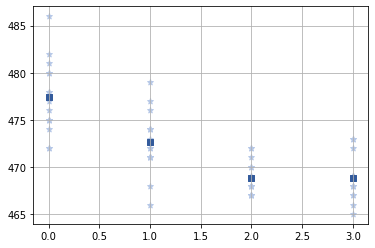

In [116]:
def a0(ordo): 
    return Genetique(ordo,20,10)

def a1(ordo): 
    return Tabou(ordo,10,50)

def a2(ordo): 
    return GenetiqueAvance(ordo,20,10,1)
def a3(ordo): 
    return GenetiqueAvance(ordo, 20, 20, 1)

algos = [a0,a1,a2,a3]

comparaisonPlot(algos, 20, 15)

### Optimisation des paramètres de l'algorithme Genetique avancé 

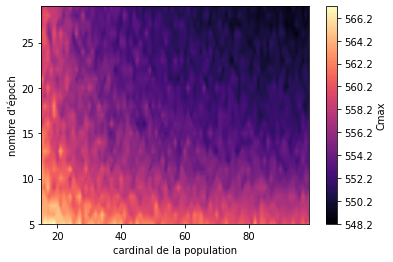

In [140]:
ordo = genOrdo(20)
x=np.arange(15,100) ##nombre de voisins
y=np.arange(5,30)  ##nombres d'itérations

X,Y=np.meshgrid(x,y)

def f(x,y):
    l = []
    for _ in range (10): 
        l.append(cout(Genetique(ordo,x,y)))
    return np.mean(np.array(l))

Z = np.array([[f(x_val, y_val) for x_val in x] for y_val in y])

plt.contourf(X,Y,Z,100,cmap='magma')
cbar=plt.colorbar()
plt.xlabel("cardinal de la population")
plt.ylabel("nombre d'époch")
cbar.set_label("Cmax")

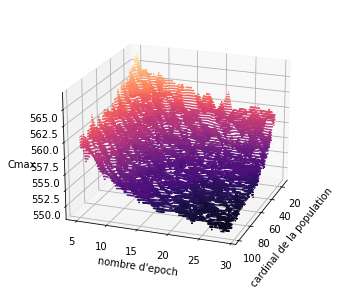

In [194]:
fig = figure = plt.figure(figsize = (5, 5)) 
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='magma')
ax.set_xlabel('cardinal de la population')
ax.set_ylabel("nombre d'epoch")
ax.set_zlabel('Cmax')
ax.view_init(20, 20)